In [79]:
import numpy as np
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import functools
import itertools
%matplotlib ipympl

In [94]:
def get_initial_balls(N, sigma, seed=10):
    key = jax.random.PRNGKey(seed)
    w = sigma * jax.random.normal(key, (N, 2))
    return w




In [98]:
def potential(w):
    x, y = w[0], w[1]
    return (1 - x)**2 + 100 * (y - x**2)**2

def get_energies(w, potential):
    energies = jax.vmap(potential, in_axes=0)(w)
    energies = energies - jnp.min(energies)
    return energies

def get_grads(w, potential):
    gradients = jax.vmap(jax.grad(potential), in_axes=0)(w)
    return gradients


def evaporate(w, energies, grads, frac):
    n_init = len(energies)
    n_final = jnp.floor(frac * n_init).astype(jnp.int32)
    ind = jnp.argsort(energies)[:n_final]
    w = w[ind, :]
    energies = energies[ind]
    grads = grads[ind, :]
    num_evaporated = n_init - n_final
    return w, energies, grads, num_evaporated

def get_mean_step_size_and_temperatue(energies, gradients):
    mean_grad_mag = jnp.mean(jnp.sqrt(jnp.sum(gradients ** 2, axis=1)))
    T = jnp.mean(energies - jnp.min(energies))
    mean_step_size = T / mean_grad_mag
    return mean_step_size, T

def condense(w, energies, grads, num_to_condense):
    new_w = jnp.ones((num_to_condense, w.shape[1])) * w[0, :]
    new_grads = jnp.ones((num_to_condense, w.shape[1])) * grads[0, :]
    new_energies = jnp.ones(num_to_condense) * energies[0]
    
    w = jnp.concat([new_w, w], axis=0)
    grads = jnp.concat([new_grads, grads], axis=0)
    energies = jnp.concat([new_energies, energies])
    
    return w, energies, grads

def thermalize(w, energies, grads, T, mean_step_size):
    return w

    
ball_generator = functools.partial(get_initial_balls, N=5, sigma=2, seed=10)
w = ball_generator()
energies = get_energies(w, potential)
grads = get_grads(w, potential)

w, energies, grads, num_evaporated = evaporate(w, energies, grads, .75)
mean_step_size, T = get_mean_step_size_and_temperatue(energies, gradients)
condense(w, energies, grads, num_evaporated)
thermalize(w, energies, grads, T, mean_step_size)


# mean_step_size, T = get_mean_step_size_and_temperatue(energies, gradients)
# mean_step_size, T


Array([[-0.25272164, -0.32128537],
       [ 0.9352776 , -0.53368753],
       [ 1.7522061 , -0.4658023 ]], dtype=float32)

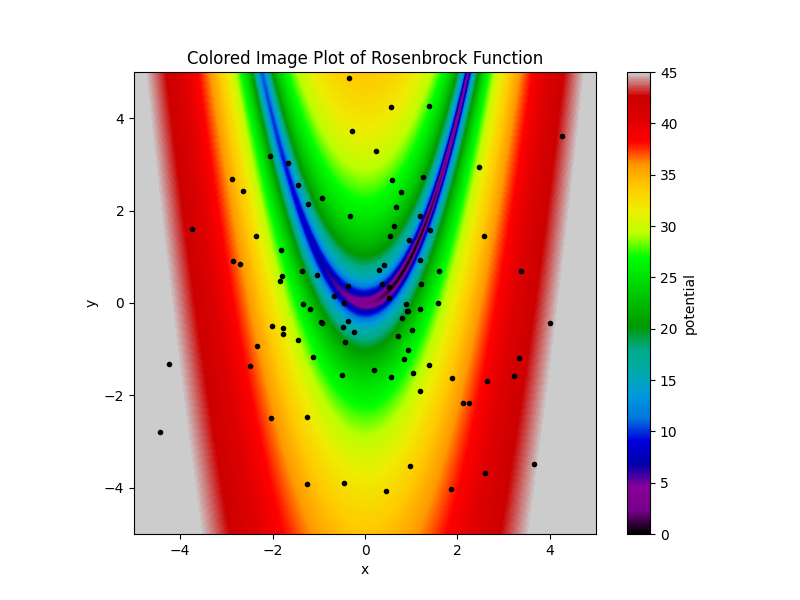

In [10]:
def plot_potential(potential, xlim=(-5, 5), ylim=(-5, 5), clim=(0, 45), db=True, ball_generator=None):
    # Generate data
    x = np.linspace(xlim[0], xlim[1], 1000)
    y = np.linspace(ylim[0], ylim[1], 1000)
    X, Y = np.meshgrid(x, y)
    Z = rosenbrock(X, Y)
    if db:
        Z = 10 * np.log10(1 + Z)    

    fig = plt.figure(figsize=(8, 6))
    cmap = 'nipy_spectral'
    plt.imshow(Z, extent=[-5, 5, -5, 5], origin='lower', cmap=cmap)
    plt.colorbar(label='potential')
    plt.clim(*clim)
    plt.title('Colored Image Plot of Rosenbrock Function')
    plt.xlabel('x')
    plt.ylabel('y')
    ax = fig.axes[0]
    if ball_generator is not None:
        W = ball_generator()
        ax.plot(W[:, 0], W[:, 1], '.', color='black')
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
    

    # ax.plot([0, 1, -1], [0, 1, -1], '.', color='black')
    return ax

ax = plot_potential(rosenbrock, ball_generator=ball_generator)
# ax.plot([0, 1, -1], [0, 1, -1], '.', color='black')